# Counterfactual analysis (run_cf)

This notebook runs tariff counterfactuals using pre-estimated BLP results and the merged vehicle cost/markup file. It prepares inputs, runs a counterfactual, and summarizes effects on prices, shares, profits, and consumer surplus.


## 1. Setup and data prep

Imports and basic cleaning for the product-level data used throughout the counterfactuals.


In [12]:
### Import libraries

import numpy as np
import pandas as pd
import dataclasses
from functools import partial
from typing import Callable
from typing import Tuple
import itertools
import pyblp
import linearmodels


### 1.1 Load and clean product data


In [13]:
# Import data (already cleaned and standardized in get_elas_div.ipynb)
# Note: prices/size/mpg/hp/weight are already scaled; do NOT rescale here.
product_data = pd.read_csv('data/raw/product_data.csv')
agent_data = pd.read_csv('data/raw/agent_data.csv')


## 2. Load estimation results


In [38]:
import pickle

# Load the results object from the file under a new name
import json
from pathlib import Path

cfg_path = Path("results_config.json")
if not cfg_path.exists():
    cfg_path = Path("post_est") / "results_config.json"
cfg = json.loads(cfg_path.read_text())
results_path = Path(cfg["results_file"])
if not results_path.is_absolute():
    results_path = (cfg_path.parent / results_path).resolve()

with open(results_path, "rb") as f:
    results = pickle.load(f)


## 3. Prepare costs and panel data

Uses the merged vehicle costs/markups file to align costs with products.


In [4]:
from helpers.counterfactual_costs_prep import prepare_costs_df2_for_year

product_data, rho_data, costs_df2, diag = prepare_costs_df2_for_year(
    product_data=product_data,
    vehicle_costs_csv="data/derived/vehicle_costs_markups_chars.csv",
    pc_panel_csv="data/raw/pc_data_panel.csv",
    year=2024,
)

pc_panel_data = rho_data  # if you want the alias
print(diag)


{'filled_from_make_model': 0, 'filled_from_firm_mean': 19, 'remaining_missing_us_pcUSCA_pct': 5}


## 4. Load counterfactual helpers

Reloads the module so edits are picked up in the current kernel.


In [15]:
import importlib
from helpers import counterfactual_helpers
importlib.reload(counterfactual_helpers)
from helpers.counterfactual_helpers import (
    run_cf_and_summarize,
    origin_percent_metrics,
    plot_origin_percent_metrics_bw
)


## 5. Run the counterfactual


In [16]:
# Define indicies
# Indices for price terms in your model
PRICE_X2_INDEX = 1   # column of prices in products.X2
PRICE_BETA_INDEX = 0  # index of mean price coef in results.beta
CS_GAMMA = 0.0  # outside good utility normalization
INCOME_DEMO_INDEX = 0  # income column in agents.demographics
INCOME_TRANSFORM = "log_10k"  # log income in 10k units -> dollars
REGION_START_INDEX = 1  # first region dummy column in demographics
REGION_LABELS = [
    "North East",
    "North Central",
    "South Atlantic",
    "South Central",
    "Mountain",
    "Pacific",
]
CS_MARKET_ID = 2024    # market id for CS diagnostics (use "2024" if ids are strings)


In [17]:
COUNTRY_TARIFFS = {
    "United Kingdom": 0.10,
    "Japan": 0.15,
    "South Korea": 0.15,
}

PARTS_TARIFF = 0.25
VEHICLE_TARIFF = 0.25

def tariff_scenario_label(parts_tariff, vehicle_tariff):
    if parts_tariff > 0 and vehicle_tariff > 0:
        return "parts and vehicle tariff"
    if parts_tariff == 0 and vehicle_tariff > 0:
        return "vehicle only tariff"
    return "custom tariff"

SCENARIO_LABEL = tariff_scenario_label(PARTS_TARIFF, VEHICLE_TARIFF)

out = run_cf_and_summarize(
    results, product_data, costs_df2,
    year=2024,
    parts_tariff=PARTS_TARIFF, vehicle_tariff=VEHICLE_TARIFF,
    price_x2_index=PRICE_X2_INDEX,
    beta_price_index=PRICE_BETA_INDEX,
    gamma=CS_GAMMA,
    country_tariffs=COUNTRY_TARIFFS
)

product_tbl = out["product_table"]
firm_tbl = out["firm_table"]


KeyError: 'product_ids'

## 6. Output summaries


### 6.1 Origin metrics (US-assembled vs foreign)


,ΔPrice (%),ΔCost (%),ΔMarkup (pp),ΔShare (pp)
origin,,,,
Foreign-assembled,+12.08,+14.67,-1.80,-4.03
US-assembled,+7.87,+9.05,-0.90,+0.10


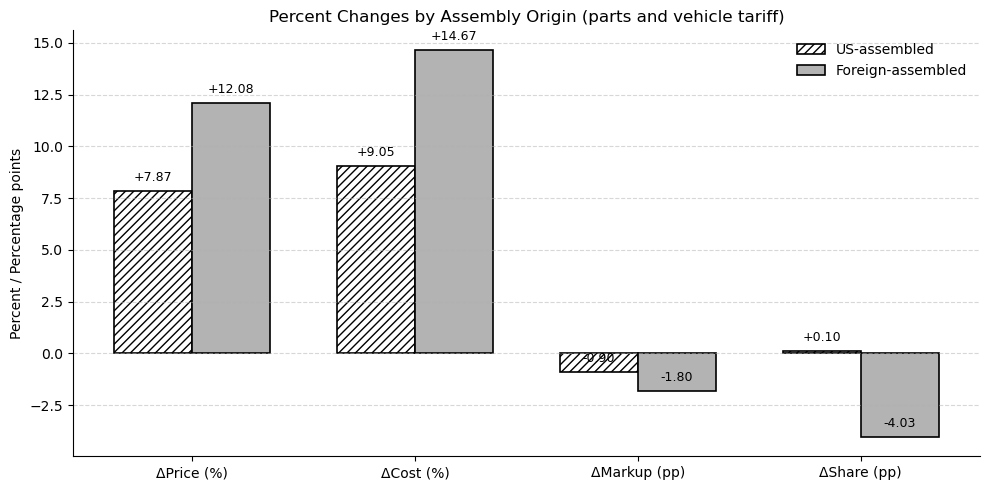

In [66]:
metrics_50 = origin_percent_metrics(product_tbl)
display(metrics_50.style.format("{:+.2f}"))
plot_origin_percent_metrics_bw(metrics_50, title=f"Percent Changes by Assembly Origin ({SCENARIO_LABEL})")


### 6.2 Total sales levels (units and value)

Computes base vs counterfactual total units and total value using the market size and price scale.


In [67]:
# Assumptions for scaling
TOTAL_MARKET_SIZE = 132_000_000 / 6  # set to your preferred market size
PRICE_SCALE_USD_PER_UNIT = 100_000.0  # prices are in 100k USD units

pt = product_tbl.copy()

units_base = TOTAL_MARKET_SIZE * pt["s0"].sum() / 1_000_000.0
units_cf = TOTAL_MARKET_SIZE * pt["s_cf"].sum() / 1_000_000.0

value_base = TOTAL_MARKET_SIZE * (pt["p0"] * pt["s0"]).sum() * PRICE_SCALE_USD_PER_UNIT / 1_000_000_000.0
value_cf = TOTAL_MARKET_SIZE * (pt["p_cf"] * pt["s_cf"]).sum() * PRICE_SCALE_USD_PER_UNIT / 1_000_000_000.0

sales_summary = pd.DataFrame({
    "scenario": ["base", "counterfactual"],
    "total_units_millions": [units_base, units_cf],
    "total_value_usd_billions": [value_base, value_cf],
})

sales_summary


,scenario,total_units_millions,total_value_usd_billions
0,base,11.350688,363.670586
1,counterfactual,10.485005,351.173429


### 6.3 Firm-level profit changes


,Panel,Firm,Δ Profit (millions USD),%Δ
0,Panel A. Largest Increases,honda,+399.6,+10.1
1,Panel A. Largest Increases,ram,+385.8,+68.9
2,Panel A. Largest Increases,tesla,+318.6,+10.1
3,Panel A. Largest Increases,toyota,+242.9,+2.7
4,Panel A. Largest Increases,jeep,+125.6,+5.0
5,Panel B. Largest Decreases,ford,-1198.7,-17.3
6,Panel B. Largest Decreases,chevrolet,-778.5,-11.5
7,Panel B. Largest Decreases,mercedesbenz,-522.5,-50.9
8,Panel B. Largest Decreases,gmc,-458.4,-18.5
9,Panel B. Largest Decreases,bmw,-403.9,-32.1


\\begin{tabular}{lrr}
\\toprule
Firm & $\\Delta$ Profit (millions USD) & \\%$\\Delta$ \\\\
\\midrule
\\multicolumn{3}{l}{\\textit{Panel A. Largest Increases}} \\\\
honda & +399.6 & +10.1 \\
ram & +385.8 & +68.9 \\
tesla & +318.6 & +10.1 \\
toyota & +242.9 & +2.7 \\
jeep & +125.6 & +5.0 \\
\\\\
\\multicolumn{3}{l}{\\textit{Panel B. Largest Decreases}} \\\\
ford & -1198.7 & -17.3 \\
chevrolet & -778.5 & -11.5 \\
mercedesbenz & -522.5 & -50.9 \\
gmc & -458.4 & -18.5 \\
bmw & -403.9 & -32.1 \\
\\bottomrule
\\end{tabular}
\\\\
\\footnotesize Notes: $\\Delta$ is CF minus baseline; \\%$\\Delta$ is the percentage change relative to baseline.


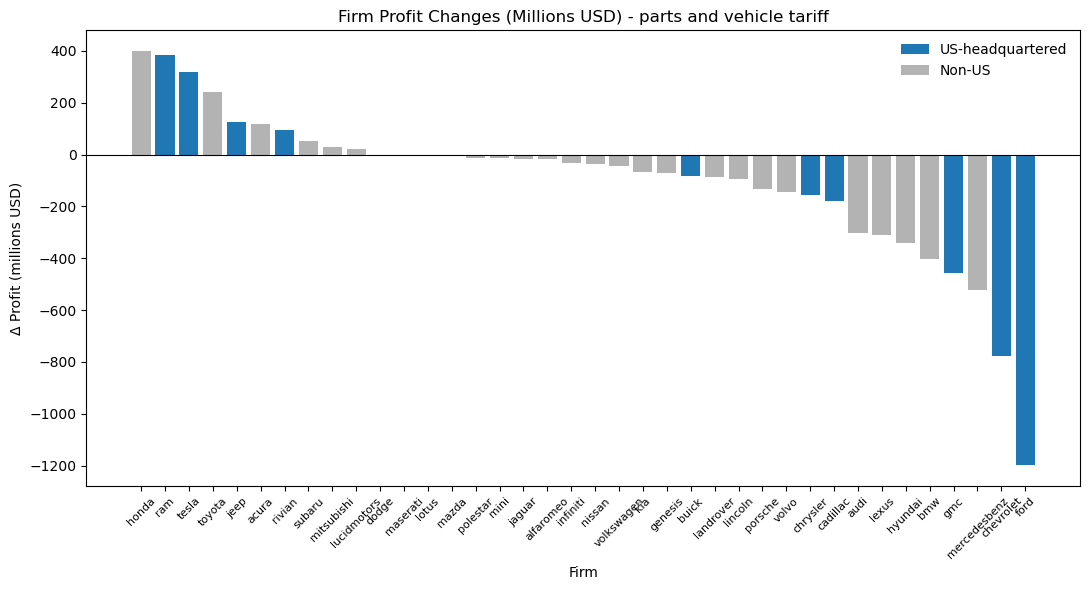

In [68]:
from helpers.counterfactual_profit_tables import profit_changes_table, profit_changes_table_latex
import numpy as np
import matplotlib.pyplot as plt

firm_tbl = out["firm_table"]

# Pretty pandas table (with Panel column + signed formatting)
tbl = profit_changes_table(firm_tbl, n=5)
display(tbl)

# LaTeX version (two-panel, booktabs style)
latex = profit_changes_table_latex(firm_tbl, n=5)
print(latex)

# Bar chart: profit change by firm (US firms in blue)
if "us_firms" not in globals():
    us_firms = [
        "ford", "chevrolet", "gmc", "buick", "cadillac", "chrysler",
        "ram", "jeep", "dodge", "tesla", "rivian", "lucid"
    ]

plot_df = firm_tbl.copy()
plot_df["firm_lower"] = plot_df["firm_ids"].astype(str).str.lower()
us_set = {f.lower() for f in us_firms}
plot_df["is_us"] = plot_df["firm_lower"].isin(us_set)
plot_df = plot_df.sort_values("dpi_millions_usd", ascending=False)

colors = ["tab:blue" if is_us else "0.7" for is_us in plot_df["is_us"]]

fig, ax = plt.subplots(figsize=(11, 6))
ax.bar(plot_df["firm_ids"].astype(str), plot_df["dpi_millions_usd"], color=colors)
ax.axhline(0, color="black", linewidth=0.8)
ax.set_title(f"Firm Profit Changes (Millions USD) - {SCENARIO_LABEL}")
ax.set_ylabel("Δ Profit (millions USD)")
ax.set_xlabel("Firm")
ax.tick_params(axis="x", rotation=45, labelsize=8)

# Legend
from matplotlib.patches import Patch
legend_handles = [
    Patch(facecolor="tab:blue", label="US-headquartered"),
    Patch(facecolor="0.7", label="Non-US"),
]
ax.legend(handles=legend_handles, frameon=False, loc="upper right")

plt.tight_layout()
plt.show()


### 6.4 US assembly by state (units)

Shows base vs counterfactual assembled units by US state using `plant_location` for vehicles with `plant_country = United States`.


In [69]:
import numpy as np
import pandas as pd

# Use the same total market size as Section 6.2 if available
if "TOTAL_MARKET_SIZE" not in globals():
    TOTAL_MARKET_SIZE = 132_000_000 / 6

pt = product_tbl.copy()
# Avoid merge suffixes by dropping any existing plant_* columns from product_tbl
pt = pt.drop(columns=[c for c in ["plant_country", "plant_location"] if c in pt.columns])

cols = ["market_ids", "product_ids", "plant_country", "plant_location"]
pd_map = product_data[cols].drop_duplicates(["market_ids", "product_ids"]).copy()
m = pt.merge(pd_map, on=["market_ids", "product_ids"], how="left")

# At this point, the columns should exist without suffixes
if "plant_country" not in m.columns or "plant_location" not in m.columns:
    raise KeyError("plant_country/plant_location not found after merge; available columns: " + ",".join(m.columns))

us_mask = m["plant_country"].astype(str).str.strip() == "United States"
m_us = m.loc[us_mask & m["plant_location"].notna()].copy()

g = m_us.groupby("plant_location", dropna=False).agg(
    s0=("s0", "sum"),
    s_cf=("s_cf", "sum"),
).reset_index()

g["units_base"] = TOTAL_MARKET_SIZE * g["s0"]
g["units_cf"] = TOTAL_MARKET_SIZE * g["s_cf"]
g["delta_units"] = g["units_cf"] - g["units_base"]
g["pct_change"] = np.where(g["units_base"] != 0, 100.0 * g["delta_units"] / g["units_base"], np.nan)

state_units = g[["plant_location", "units_base", "units_cf", "delta_units", "pct_change"]].sort_values("delta_units")
state_units

# --- US state map (percent change) ---
STATE_ABBR = {
    "Alabama": "AL", "Alaska": "AK", "Arizona": "AZ", "Arkansas": "AR",
    "California": "CA", "Colorado": "CO", "Connecticut": "CT", "Delaware": "DE",
    "Florida": "FL", "Georgia": "GA", "Hawaii": "HI", "Idaho": "ID",
    "Illinois": "IL", "Indiana": "IN", "Iowa": "IA", "Kansas": "KS",
    "Kentucky": "KY", "Louisiana": "LA", "Maine": "ME", "Maryland": "MD",
    "Massachusetts": "MA", "Michigan": "MI", "Minnesota": "MN", "Mississippi": "MS",
    "Missouri": "MO", "Montana": "MT", "Nebraska": "NE", "Nevada": "NV",
    "New Hampshire": "NH", "New Jersey": "NJ", "New Mexico": "NM", "New York": "NY",
    "North Carolina": "NC", "North Dakota": "ND", "Ohio": "OH", "Oklahoma": "OK",
    "Oregon": "OR", "Pennsylvania": "PA", "Rhode Island": "RI", "South Carolina": "SC",
    "South Dakota": "SD", "Tennessee": "TN", "Texas": "TX", "Utah": "UT",
    "Vermont": "VT", "Virginia": "VA", "Washington": "WA", "West Virginia": "WV",
    "Wisconsin": "WI", "Wyoming": "WY",
}

STATE_CENTROIDS = {
    "AL": (32.806671, -86.791130), "AK": (61.370716, -152.404419),
    "AZ": (33.729759, -111.431221), "AR": (34.969704, -92.373123),
    "CA": (36.116203, -119.681564), "CO": (39.059811, -105.311104),
    "CT": (41.597782, -72.755371), "DE": (39.318523, -75.507141),
    "FL": (27.766279, -81.686783), "GA": (33.040619, -83.643074),
    "HI": (21.094318, -157.498337), "ID": (44.240459, -114.478828),
    "IL": (40.349457, -88.986137), "IN": (39.849426, -86.258278),
    "IA": (42.011539, -93.210526), "KS": (38.526600, -96.726486),
    "KY": (37.668140, -84.670067), "LA": (31.169546, -91.867805),
    "ME": (44.693947, -69.381927), "MD": (39.063946, -76.802101),
    "MA": (42.230171, -71.530106), "MI": (43.326618, -84.536095),
    "MN": (45.694454, -93.900192), "MS": (32.741646, -89.678696),
    "MO": (38.456085, -92.288368), "MT": (46.921925, -110.454353),
    "NE": (41.125370, -98.268082), "NV": (38.313515, -117.055374),
    "NH": (43.452492, -71.563896), "NJ": (40.298904, -74.521011),
    "NM": (34.840515, -106.248482), "NY": (42.165726, -74.948051),
    "NC": (35.630066, -79.806419), "ND": (47.528912, -99.784012),
    "OH": (40.388783, -82.764915), "OK": (35.565342, -96.928917),
    "OR": (44.572021, -122.070938), "PA": (40.590752, -77.209755),
    "RI": (41.680893, -71.511780), "SC": (33.856892, -80.945007),
    "SD": (44.299782, -99.438828), "TN": (35.747845, -86.692345),
    "TX": (31.054487, -97.563461), "UT": (40.150032, -111.862434),
    "VT": (44.045876, -72.710686), "VA": (37.769337, -78.169968),
    "WA": (47.400902, -121.490494), "WV": (38.491226, -80.954453),
    "WI": (44.268543, -89.616508), "WY": (42.755966, -107.302490),
}

state_map = state_units.copy()
state_map["state_abbr"] = state_map["plant_location"].map(STATE_ABBR)
state_map = state_map.dropna(subset=["state_abbr"]).copy()

all_states = list(STATE_ABBR.values())

abs_vals = np.abs(state_map["pct_change"].to_numpy(dtype=float))
abs_vals = abs_vals[np.isfinite(abs_vals)]
if len(abs_vals) == 0:
    zmax = 1.0
else:
    zmax = np.nanpercentile(abs_vals, 90)
    if not np.isfinite(zmax) or zmax <= 0:
        zmax = np.nanmax(abs_vals)
    zmax = max(zmax, 20.0)

try:
    import plotly.graph_objects as go

    fig = go.Figure()
    fig.add_trace(
        go.Choropleth(
            locations=all_states,
            locationmode="USA-states",
            z=[0] * len(all_states),
            colorscale=[[0, "#e0e0e0"], [1, "#e0e0e0"]],
            showscale=False,
            marker_line_color="white",
            marker_line_width=0.5,
            hoverinfo="skip",
        )
    )

    fig.add_trace(
        go.Choropleth(
            locations=state_map["state_abbr"],
            locationmode="USA-states",
            z=state_map["pct_change"],
            colorscale="RdBu",
            zmid=0,
            zmin=-zmax,
            zmax=zmax,
            colorbar_title="% change",
            marker_line_color="white",
            marker_line_width=0.5,
            hovertemplate="%{location}: %{z:.2f}%<extra></extra>",
        )
    )

    # State labels (only where we have data): code + % change
    label_states = state_map["state_abbr"].tolist()
    label_lats = [STATE_CENTROIDS[s][0] for s in label_states]
    label_lons = [STATE_CENTROIDS[s][1] for s in label_states]
    label_text = [
        f"{s}<br>{v:+.1f}%" for s, v in zip(label_states, state_map["pct_change"])
    ]
    fig.add_trace(
        go.Scattergeo(
            locationmode="USA-states",
            lat=label_lats,
            lon=label_lons,
            text=label_text,
            mode="text",
            textfont=dict(size=9, color="black"),
            hoverinfo="skip",
        )
    )

    fig.update_layout(
        title=f"US Assembly % Change by State ({SCENARIO_LABEL})",
        geo_scope="usa",
        margin={"r": 0, "t": 40, "l": 0, "b": 0},
    )
    fig.show(renderer="browser")
except ImportError:
    print("Plotly is required for the US map. Install with: pip install plotly")


## 7. Consumer surplus by income

Set the indices below once, then reuse across the CS blocks.
If your demographic column is log(income in 10k units), keep `INCOME_TRANSFORM = "log_10k"` so bins are computed in income levels.
Region indicators are assumed to live in demographics columns 1–6 (one-hot), with labels in `REGION_LABELS`.


In [234]:
# Indices for price terms in your model
PRICE_X2_INDEX = 1   # column of prices in products.X2
PRICE_BETA_INDEX = 0  # index of mean price coef in results.beta
CS_GAMMA = 0.0  # outside good utility normalization
INCOME_DEMO_INDEX = 0  # income column in agents.demographics
INCOME_TRANSFORM = "log_10k"  # log income in 10k units -> dollars
REGION_START_INDEX = 1  # first region dummy column in demographics
REGION_LABELS = [
    "North East",
    "North Central",
    "South Atlantic",
    "South Central",
    "Mountain",
    "Pacific",
]
CS_MARKET_ID = 2024    # market id for CS diagnostics (use "2024" if ids are strings)


### 7.1 CS by income bins (creates cs_income_table)

`cs_income_table` is used by the summary table below. The CS values are in the same units as `cs_change_by_income_bins` returns.


In [235]:
import importlib
from helpers import consumer_surplus
importlib.reload(consumer_surplus)
from helpers.consumer_surplus import cs_change_by_income_bins


# ---------- example run ----------
mid = CS_MARKET_ID
tbl = cs_change_by_income_bins(
    results,
    out["product_table"],
    market_id=mid,
    price_x2_index=PRICE_X2_INDEX,
    beta_price_index=PRICE_BETA_INDEX,
    income_demo_index=INCOME_DEMO_INDEX,
    income_transform=INCOME_TRANSFORM,
    n_bins=5,
    gamma=0.0
)

cs_income_table = (
    tbl.rename(columns={"CS0": "cs0", "CS_cf": "cs_cf"})
       .assign(income_quintile=lambda d: d["bin"].map(lambda b: f"Q{int(b)}"))
)

out["cs_income_table"] = cs_income_table


In [236]:
display(tbl)


,bin,CS0,CS_cf,dCS,pct_change_vs_baseline,income_min,income_max,weight_mass
0,1,0.019415,0.018239,-0.001176,-6.055657,15.841286,25742.088961,0.199890
1,2,0.050935,0.046953,-0.003981,-7.816489,25979.708244,48791.159385,0.199244
2,3,0.098024,0.091966,-0.006058,-6.179997,49107.985095,77622.299022,0.200034
3,4,0.182750,0.173898,-0.008852,-4.843871,77701.505449,120552.182766,0.200430
4,5,0.431885,0.417711,-0.014174,-3.281862,120869.008477,872854.831855,0.200401


### 7.2 Summary table (producer surplus + CS by income)

Uses `firm_table` from `out` and `cs_income_table` created above. Update column names if you switch units.


In [237]:
import pandas as pd
import numpy as np

def build_counterfactual_summary(
    firm_tbl: pd.DataFrame,
    cs_tbl: pd.DataFrame,
    us_firms,
    income_order,
    firm_col="firm_ids",
    profit_base_col="pi0_millions_usd",
    profit_cf_col="pi_cf_millions_usd",
    cs_base_col="cs0",
    cs_cf_col="cs_cf",
) -> pd.DataFrame:
    """
    Build a summary table with:
      - Aggregate producer surplus
      - US vs non-US firm producer surplus
      - Consumer surplus by income quintile

    Assumes:
      firm_tbl has columns: [firm_col, profit_base_col, profit_cf_col]
      cs_tbl   has columns: ['income_quintile', cs_base_col, cs_cf_col]
      profits and CS are in the units of the columns you pass in.
    """

    df_f = firm_tbl.copy()
    df_f["firm_lower"] = df_f[firm_col].astype(str).str.lower()
    us_set = {f.lower() for f in us_firms}
    df_f["is_us"] = df_f["firm_lower"].isin(us_set)

    # --- Producer surplus (aggregate) ---
    ps_base = df_f[profit_base_col].sum()
    ps_cf   = df_f[profit_cf_col].sum()
    d_ps    = ps_cf - ps_base
    pct_ps  = 100 * d_ps / ps_base

    # --- Producer surplus by firm nationality ---
    def agg_ps(mask):
        base = df_f.loc[mask, profit_base_col].sum()
        cf   = df_f.loc[mask, profit_cf_col].sum()
        d    = cf - base
        pct  = 100 * d / base if base != 0 else np.nan
        return d, pct

    d_ps_us,   pct_ps_us   = agg_ps(df_f["is_us"])
    d_ps_non,  pct_ps_non  = agg_ps(~df_f["is_us"])

    # --- Consumer surplus by income quintile ---
    df_cs = cs_tbl.copy()
    cs_agg = (
        df_cs
        .groupby("income_quintile")[[cs_base_col, cs_cf_col]]
        .sum()
        .reindex(income_order)
    )

    cs_rows = []
    for inc in income_order:
        base = cs_agg.loc[inc, cs_base_col]
        cf   = cs_agg.loc[inc, cs_cf_col]
        d    = cf - base
        pct  = 100 * d / base if base != 0 else np.nan
        cs_rows.append((inc, d, pct))

    # --- Assemble table (values in millions of USD) ---
    rows = []

    # Panel A: aggregate PS
    rows.append(("Panel A. Aggregate outcomes", "Producer surplus",
                 d_ps, pct_ps))

    # Panel A2: PS by firm nationality
    rows.append(("Panel A2. Producer surplus by firm origin",
                 "US firms", d_ps_us, pct_ps_us))
    rows.append(("Panel A2. Producer surplus by firm origin",
                 "Non-US firms", d_ps_non, pct_ps_non))

    # Panel B: CS by income quintile
    for inc, d, pct in cs_rows:
        label = f"Q{inc}" if isinstance(inc, int) else str(inc)
        rows.append(("Panel B. Consumer surplus by income",
                     label, d, pct))

    summary = pd.DataFrame(
        rows,
        columns=["Panel", "Outcome", "Δ", "%Δ"]
    )

    return summary


# ---------- Example usage ----------

# 1. Define which firms you treat as "US firms"
us_firms = [
    "ford", "chevrolet", "gmc", "buick", "cadillac", "chrysler",
    "ram", "jeep", "dodge", "tesla", "rivian", "lucid"
]

# 2. Define income order (whatever labels you use in cs_tbl)
income_order = ["Q1", "Q2", "Q3", "Q4", "Q5"]  # or e.g. ["<40k", "40-75k", ...]

# 3. Build the summary table for your counterfactual
summary_tbl = build_counterfactual_summary(
    firm_tbl=out["firm_table"],        # <-- your firm-level profit results
    cs_tbl=cs_income_table,     # <-- your CS-by-income results
    us_firms=us_firms,
    firm_col="firm_ids",
    income_order=income_order,
    profit_base_col="pi0_millions_usd",         # adapt to your column names
    profit_cf_col="pi_cf_millions_usd",
    cs_base_col="cs0",
    cs_cf_col="cs_cf"
)

print(summary_tbl)

# 4. LaTeX version (single-scenario, Δ and %Δ columns)
latex = summary_tbl.to_latex(
    index=False,
    float_format=lambda x: f"{x:0.1f}",
    column_format="llrr",
    escape=False,
    caption="Counterfactual outcomes: 25\\% vehicles \& parts",
    label="tab:counterfactual_summary"
)
print(latex)


                                       Panel           Outcome            Δ  \
0                Panel A. Aggregate outcomes  Producer surplus -1253.010956   
1  Panel A2. Producer surplus by firm origin          US firms  1244.224657   
2  Panel A2. Producer surplus by firm origin      Non-US firms -2497.235614   
3        Panel B. Consumer surplus by income                Q1    -0.001176   
4        Panel B. Consumer surplus by income                Q2    -0.003981   
5        Panel B. Consumer surplus by income                Q3    -0.006058   
6        Panel B. Consumer surplus by income                Q4    -0.008852   
7        Panel B. Consumer surplus by income                Q5    -0.014174   

         %Δ  
0 -2.106120  
1  5.090296  
2 -7.124628  
3 -6.055657  
4 -7.816489  
5 -6.179997  
6 -4.843871  
7 -3.281862  
\begin{table}
\caption{Counterfactual outcomes: 25\% vehicles \& parts}
\label{tab:counterfactual_summary}
\begin{tabular}{llrr}
\toprule
Panel & Outcome & Δ & %Δ

### 7.3 CS by region and income bins

Computes CS changes by region (division dummies) and income bins within each region.
Includes an aggregate row per region with `bin = "All"`.


In [246]:
import importlib
from helpers import consumer_surplus
importlib.reload(consumer_surplus)
from helpers.consumer_surplus import cs_change_by_region_income_bins

region_income_tbl = cs_change_by_region_income_bins(
    results,
    out["product_table"],
    market_id=CS_MARKET_ID,
    price_x2_index=PRICE_X2_INDEX,
    beta_price_index=PRICE_BETA_INDEX,
    income_demo_index=INCOME_DEMO_INDEX,
    income_transform=INCOME_TRANSFORM,
    region_start_index=REGION_START_INDEX,
    region_labels=REGION_LABELS,
    n_bins=5,
    gamma=0.0,
)

out["cs_region_income_table"] = region_income_tbl
region_income_tbl


,region,bin,CS0,CS_cf,dCS,pct_change_vs_baseline,income_min,income_max,weight_mass
0,North East,All,0.155535,0.140959,-0.014576,-9.371434,182.174783,776222.990216,1.0000
1,North East,1,0.027714,0.024268,-0.003446,-12.435534,182.174783,24950.024686,0.1975
2,North East,2,0.033078,0.027478,-0.005600,-16.930596,25346.056823,49900.049371,0.2000
3,North East,3,0.093457,0.082272,-0.011185,-11.968506,50375.287936,81582.620400,0.2000
4,North East,4,0.186808,0.164360,-0.022448,-12.016422,82374.684676,133383.624033,0.2000
5,North East,5,0.431568,0.401699,-0.029869,-6.921066,133858.862599,776222.990216,0.2025
6,North Central,All,0.176910,0.161067,-0.015843,-8.955301,23.761928,548821.336654,1.0000
7,North Central,1,0.009366,0.007406,-0.001961,-20.931681,23.761928,23761.928272,0.1975
8,North Central,2,0.065308,0.056425,-0.008883,-13.601302,24950.024686,45385.282999,0.2000
9,North Central,3,0.137576,0.120597,-0.016978,-12.341079,45622.902282,71285.784816,0.2000


## Appendix B. Outside-option switching by income (optional)


In [239]:
from helpers.consumer_surplus import switch_to_outside_by_income

tbl = switch_to_outside_by_income(
    results,
    out["product_table"],
    market_id=CS_MARKET_ID,
    price_x2_index=PRICE_X2_INDEX,
    beta_price_index=PRICE_BETA_INDEX,
    income_demo_index=INCOME_DEMO_INDEX,
    income_transform=INCOME_TRANSFORM,
    n_bins=5,
    gamma=0.0,
    simulate_switches=True,
    seed=123
)

print(tbl)


   bin  outside_share0  outside_share_cf  delta_outside_pp     income_min  \
0    1        0.884841          0.895423          1.058201      15.841286   
1    2        0.694159          0.715575          2.141619   25979.708244   
2    3        0.502555          0.532030          2.947563   49107.985095   
3    4        0.276829          0.300871          2.404139   77701.505449   
4    5        0.064213          0.075805          1.159288  120869.008477   

      income_max  sim_switch_inside_to_outside  
0   25742.088961                      1.553391  
1   48791.159385                      2.328461  
2   77622.299022                      2.286115  
3  120552.182766                      2.088265  
4  872854.831855                      0.987681  


## Appendix C. Alternative summary table (experimental)

Requires the helper functions defined in the next cell.


In [240]:
import importlib
from helpers import cf_summary_table
importlib.reload(cf_summary_table)
from helpers.cf_summary_table import build_qje_style_summary_table, format_table


In [241]:
#from cf_summary_table import build_qje_style_summary_table, format_table

out_veh = run_cf_and_summarize(
    results, product_data, costs_df2,
    year=2024,
    parts_tariff=0.00, vehicle_tariff=0.25,
    price_x2_index=PRICE_X2_INDEX,
    beta_price_index=PRICE_BETA_INDEX,
    gamma=CS_GAMMA,
    country_tariffs=COUNTRY_TARIFFS
)

out_veh_parts = run_cf_and_summarize(
    results, product_data, costs_df2,
    year=2024,
    parts_tariff=0.25, vehicle_tariff=0.25,
    price_x2_index=PRICE_X2_INDEX,
    beta_price_index=PRICE_BETA_INDEX,
    gamma=CS_GAMMA,
    country_tariffs=COUNTRY_TARIFFS
)

scenarios = {
    "25% Vehicles Only": out_veh,          # output of run_cf_and_summarize(...)
    "25% Vehicles & Parts": out_veh_parts  # output of run_cf_and_summarize(...)
}

tbl = build_qje_style_summary_table(
    scenarios,
    results=results,
    product_data=product_data,
    market_id=2024,
    price_x2_index=PRICE_X2_INDEX,        # the column of prices in products.X2
    beta_price_index=PRICE_BETA_INDEX,    # index of mean price coef in results.beta
    income_demo_index=INCOME_DEMO_INDEX,
    income_transform=INCOME_TRANSFORM,
    total_market_size=132_000_000 / 6,  # same number you use elsewhere
    gamma=0.0,
    product_id_field_in_results="clustering_ids",  # per your fix
    table_id_col="product_ids",
)

display(format_table(tbl, delta_decimals=1, pct_decimals=1))


Computing marginal costs ...
Finished after 00:00:00.

Solving for equilibrium prices ...
Finished after 00:00:01.

Computing shares ...
Finished after 00:00:00.

Computing shares ...
Finished after 00:00:00.

Computing marginal costs ...
Finished after 00:00:00.

Computing marginal costs ...
Finished after 00:00:00.

Solving for equilibrium prices ...
Finished after 00:00:01.

Computing shares ...
Finished after 00:00:00.

Computing shares ...
Finished after 00:00:00.

Computing marginal costs ...
Finished after 00:00:00.



25% Vehicles Only  \
                                                                                           Δ   
(, Panel)                                          (, Outcome)                                 
Panel A. Aggregate outcomes                        Producer Surplus                  -1253.0   
                                                   Total Cars Sold (units)         -427246.1   
Panel A2. Producer surplus by firm origin (mill... US firms                          +2622.4   
                                                   Non-US firms                      -3875.4   
Panel B. Consumer surplus by income quintile (m... Q1                                 -517.0   
                                                   Q2                                -1751.7   
                                                   Q3                                -2668.9   
                                                   Q4                                -3893.9   
                                                   Q5                                -6249.0   

                                                                                   \
                                                                               %Δ   
(, Panel)                                          (, Outcome)                      
Panel A. Aggregate outcomes                        Producer Surplus          -2.1   
                                                   Total Cars Sold (units)   -3.8   
Panel A2. Producer surplus by firm origin (mill... US firms                  +8.6   
                                                   Non-US firms             -13.4   
Panel B. Consumer surplus by income quintile (m... Q1                        -6.1   
                                                   Q2                        -7.5   
                                                   Q3                        -6.2   
                                                   Q4                        -4.9   
                                                   Q5                        -3.3   

                                                                           25% Vehicles & Parts  \
                                                                                              Δ   
(, Panel)                                          (, Outcome)                                    
Panel A. Aggregate outcomes                        Producer Surplus                     -3799.1   
                                                   Total Cars Sold (units)            -879269.1   
Panel A2. Producer surplus by firm origin (mill... US firms                             -1673.7   
                                                   Non-US firms                         -2125.3   
Panel B. Consumer surplus by income quintile (m... Q1                                   -1204.0   
                                                   Q2                                   -3475.2   
                                                   Q3                                   -5793.7   
                                                   Q4                                   -9145.7   
                                                   Q5                                  -13345.0   

                                                                                   
                                                                               %Δ  
(, Panel)                                          (, Outcome)                     
Panel A. Aggregate outcomes                        Producer Surplus          -6.4  
                                                   Total Cars Sold (units)   -7.7  
Panel A2. Producer surplus by firm origin (mill... US firms                  -5.5  
                                                   Non-US firms              -7.3  
Panel B. Consumer surplus by income quintile (m... Q1                       -14.1  
                                        

## Appendix D. EV tariff table (optional)


In [242]:
import importlib
from helpers import ev_tariff_metrics
importlib.reload(ev_tariff_metrics)

from helpers.ev_tariff_metrics import build_ev_and_tariff_table
out_veh = run_cf_and_summarize(
    results, product_data, costs_df2,
    year=2024,
    parts_tariff=0.00, vehicle_tariff=0.25,
    price_x2_index=PRICE_X2_INDEX,
    beta_price_index=PRICE_BETA_INDEX,
    gamma=CS_GAMMA,
    country_tariffs=COUNTRY_TARIFFS
)
out_veh_parts = run_cf_and_summarize(
    results, product_data, costs_df2,
    year=2024,
    parts_tariff=0.25, vehicle_tariff=0.25,
    price_x2_index=PRICE_X2_INDEX,
    beta_price_index=PRICE_BETA_INDEX,
    gamma=CS_GAMMA,
    country_tariffs=COUNTRY_TARIFFS
)

scenarios = {
    "25% Vehicles Only": {"out": out_veh, "vehicle_tariff": 0.25, "parts_tariff": 0.0, "country_tariffs": COUNTRY_TARIFFS},
    "25% Vehicles & Parts": {"out": out_veh_parts, "vehicle_tariff": 0.25, "parts_tariff": 0.25, "country_tariffs": COUNTRY_TARIFFS},
}

tbl = build_ev_and_tariff_table(
    scenarios,
    product_data=product_data,
    costs_df2=costs_df2,
    market_id=2024,              # or "2024" if your market_ids are strings
    total_market_size=132_000_000 / 6,
    price_scale_usd_per_unit=100_000.0,  # if your prices/costs are in USD/100k units
)

tbl


Computing marginal costs ...
Finished after 00:00:00.

Solving for equilibrium prices ...
Finished after 00:00:01.

Computing shares ...
Finished after 00:00:00.

Computing shares ...
Finished after 00:00:00.

Computing marginal costs ...
Finished after 00:00:00.

Computing marginal costs ...
Finished after 00:00:00.

Solving for equilibrium prices ...
Finished after 00:00:01.

Computing shares ...
Finished after 00:00:00.

Computing shares ...
Finished after 00:00:00.

Computing marginal costs ...
Finished after 00:00:00.



,Scenario,EV share (baseline),EV share (CF),Δ EV share (pp),Units (baseline),Units (CF),Tariff revenue – vehicles (million USD),Tariff revenue – parts (million USD),Tariff revenue – total (million USD),parts_tariff,vehicle_tariff,market_id
0,25% Vehicles Only,0.073876,0.067794,-0.608172,1.135069e+07,1.092344e+07,15607.258133,0.000000,15607.258133,0.00,0.25,2024
1,25% Vehicles & Parts,0.073876,0.068519,-0.535720,1.135069e+07,1.047142e+07,19804.769154,21363.368613,41168.137768,0.25,0.25,2024


## Appendix E. EV subsidy removal


In [64]:
import pyblp
import numpy as np
import pandas as pd

# 1) Build a baseline-aligned product table (subsidies intact)
product_base = product_data.copy()
if "product_ids" not in product_base.columns and "clustering_ids" in product_base.columns:
    product_base["product_ids"] = product_base["clustering_ids"].astype(str)

order_df = pd.DataFrame({
    "product_ids": np.asarray(results.problem.products.clustering_ids).reshape(-1),
    "market_ids": np.asarray(results.problem.products.market_ids).reshape(-1),
})

product_base = order_df.merge(
    product_base,
    on=["product_ids", "market_ids"],
    how="left",
    validate="one_to_one",
)

# Filter to 2024 only
product_base = product_base[product_base["market_ids"] == 2024].copy()

levels = sorted(set(int(x) for x in np.asarray(product_base["market_ids"]).reshape(-1)))
product_base["market_ids"] = product_base["market_ids"].astype(int)
product_base["market_ids"] = pd.Categorical(product_base["market_ids"], categories=levels)

# 2) Build counterfactual product table: subsidy set to zero (same ordering)
product_cf = product_base.copy()
product_cf["subsidy"] = 0.0

# 3) Build non-absorbed X1 (same formula, no absorb)
x1_formula = results.problem.product_formulations[0]._formula
X1_formulation_noabs = pyblp.Formulation(x1_formula)
X2_formulation = results.problem.product_formulations[1]
product_formulations_noabs = (X1_formulation_noabs, X2_formulation)

# 4) Reconstruct beta/xi ON BASELINE DATA ONLY
X1_base, *_ = X1_formulation_noabs._build_matrix(product_base)
delta0_full = np.asarray(results.delta).reshape(-1)
mid_full = np.asarray(results.problem.products.market_ids).reshape(-1)
mask = mid_full == 2024
delta0 = delta0_full[mask]

beta_full = np.linalg.lstsq(X1_base, delta0, rcond=None)[0].reshape(-1, 1)
xi_full = (delta0 - X1_base @ beta_full.reshape(-1)).reshape(-1, 1)

print("K1 baseline:", X1_base.shape[1], "beta_full length:", beta_full.shape[0])

# 5) Filter agent_data to 2024 only
agent_df = pd.DataFrame(agent_data).copy()
agent_df = agent_df[agent_df["market_ids"].isin([2024])].copy()

# 6) Simulation with fixed unobservables (xi)
sim = pyblp.Simulation(
    product_formulations=product_formulations_noabs,
    product_data=product_cf,
    beta=beta_full,
    sigma=results.sigma,
    pi=results.pi,
    rho=results.rho,
    gamma=results.gamma,
    agent_formulation=results.problem.agent_formulation,
    agent_data=agent_df,
    xi=xi_full,
)

# 7) Solve for equilibrium prices and shares under subsidy removal
costs_full = np.asarray(results.compute_costs()).reshape(-1)
c0 = costs_full[mask]
sim_results = sim.replace_endogenous(costs=c0)


K1 baseline: 56 beta_full length: 56
Initializing the simulation ...
Initialized the simulation after 00:00:00.

Dimensions:
 T    N     F     I     K1    K2    D 
---  ----  ---  -----  ----  ----  ---
10   2982  40   24000   56    12    7 

Formulations:
       Column Indices:               0                1               2             3              4            5         6            7                 8                 9                 10                11                12                13                14                15                   16                       17                       18                       19                       20                       21                       22                       23                       24              25           26                   27                   28                   29                   30                   31                   32                   33                   34            35      36                37    

In [113]:
import numpy as np
import pandas as pd
import pyblp

YEAR = 2024

# ---------- helpers ----------

def _align_product_data_for_sim(product_df):
    df = product_df.copy()
    if "product_ids" not in df.columns and "clustering_ids" in df.columns:
        df["product_ids"] = df["clustering_ids"].astype(str)

    order_df = pd.DataFrame({
        "product_ids": np.asarray(results.problem.products.clustering_ids).reshape(-1),
        "market_ids": np.asarray(results.problem.products.market_ids).reshape(-1),
    })

    df = order_df.merge(
        df,
        on=["product_ids", "market_ids"],
        how="left",
        validate="one_to_one",
    )

    levels = sorted(set(int(x) for x in np.asarray(order_df["market_ids"]).reshape(-1)))
    df["market_ids"] = df["market_ids"].astype(int)
    df["market_ids"] = pd.Categorical(df["market_ids"], categories=levels)
    return df


def _run_sim(product_df, beta_full, xi_full, fixed_prices=None):
    df = _align_product_data_for_sim(product_df)

    sim = pyblp.Simulation(
        product_formulations=(X1_formulation_noabs, X2_formulation),
        product_data=df,
        beta=beta_full,
        sigma=results.sigma,
        pi=results.pi,
        rho=results.rho,
        gamma=results.gamma,
        agent_formulation=results.problem.agent_formulation,
        agent_data=agent_data,
        xi=xi_full,
    )

    costs_full = np.asarray(results.compute_costs()).reshape(-1)

    if fixed_prices is not None:
        fixed_prices = np.asarray(fixed_prices).reshape(-1)
        sim_results = sim.replace_endogenous(
            costs=costs_full,
            prices=fixed_prices,
            iteration=pyblp.Iteration("return"),
        )
    else:
        sim_results = sim.replace_endogenous(costs=costs_full)

    return sim_results, df


def _firm_profit_table(sim_results, total_market_size, price_scale_usd_per_unit, year_mask=None,
                       shares_override=None, prices_override=None, costs_override=None, firm_ids_override=None):
    pdata = sim_results.product_data
    firm_ids = np.asarray(pdata["firm_ids"]).reshape(-1) if firm_ids_override is None else np.asarray(firm_ids_override).reshape(-1)

    prices = np.asarray(pdata["prices"]).reshape(-1) if prices_override is None else np.asarray(prices_override).reshape(-1)
    shares = np.asarray(pdata["shares"]).reshape(-1) if shares_override is None else np.asarray(shares_override).reshape(-1)

    if costs_override is None:
        costs = sim_results.costs
        if costs is None:
            costs = results.compute_costs()
        costs = np.asarray(costs).reshape(-1)
    else:
        costs = np.asarray(costs_override).reshape(-1)

    if year_mask is not None and firm_ids_override is None:
        # only slice full-length vectors; override arrays are already year-specific
        if prices_override is None:
            prices = prices[year_mask]
        if shares_override is None:
            shares = shares[year_mask]
        if costs_override is None and costs.shape[0] == year_mask.shape[0]:
            costs = costs[year_mask]
        firm_ids = firm_ids[year_mask]

    pi_percap = (prices - costs) * shares
    factor_musd = float(total_market_size) * (price_scale_usd_per_unit / 1_000_000.0)
    pi_musd = pi_percap * factor_musd

    df = pd.DataFrame({
        "firm_ids": firm_ids,
        "pi_millions_usd": pi_musd,
    })
    return df.groupby("firm_ids", dropna=False)["pi_millions_usd"].sum().reset_index()


def _firm_ev_units(sim_results, product_df, total_market_size, year_mask=None,
                    shares_override=None, firm_ids_override=None, product_ids_override=None, market_ids_override=None):
    pdata = sim_results.product_data

    firm_ids = np.asarray(pdata["firm_ids"]).reshape(-1) if firm_ids_override is None else np.asarray(firm_ids_override).reshape(-1)
    product_ids = np.asarray(pdata["product_ids"]).reshape(-1) if product_ids_override is None else np.asarray(product_ids_override).reshape(-1)
    market_ids = np.asarray(pdata["market_ids"]).reshape(-1) if market_ids_override is None else np.asarray(market_ids_override).reshape(-1)
    shares = np.asarray(pdata["shares"]).reshape(-1) if shares_override is None else np.asarray(shares_override).reshape(-1)

    if year_mask is not None and shares_override is None:
        firm_ids = firm_ids[year_mask]
        product_ids = product_ids[year_mask]
        market_ids = market_ids[year_mask]
        shares = shares[year_mask]

    sim_df = pd.DataFrame({
        "product_ids": product_ids,
        "market_ids": market_ids,
        "firm_ids": firm_ids,
        "shares": shares,
    })

    meta = product_df[["product_ids", "market_ids", "ev", "plant_country"]].copy()
    meta["product_ids"] = meta["product_ids"].astype(str)

    m = sim_df.merge(meta, on=["product_ids", "market_ids"], how="left")
    m["units"] = m["shares"] * float(total_market_size)
    m["ev_flag"] = m["ev"].fillna(0).astype(int)
    m["us_flag"] = m["plant_country"].astype(str).eq("United States").astype(int)

    m["ev_units"] = m["units"] * m["ev_flag"]
    m["us_ev_units"] = m["units"] * m["ev_flag"] * m["us_flag"]

    out = m.groupby("firm_ids", dropna=False)[["ev_units", "us_ev_units"]].sum().reset_index()
    return out


# ---------- build baseline beta/xi on FULL sample ----------
full_aligned = _align_product_data_for_sim(product_data)

x1_formula = results.problem.product_formulations[0]._formula
X1_formulation_noabs = pyblp.Formulation(x1_formula)
X2_formulation = results.problem.product_formulations[1]

X1_full, *_ = X1_formulation_noabs._build_matrix(full_aligned)
delta0_full = np.asarray(results.delta).reshape(-1)

beta_full = np.linalg.lstsq(X1_full, delta0_full, rcond=None)[0].reshape(-1, 1)
xi_full = (delta0_full - X1_full @ beta_full.reshape(-1)).reshape(-1, 1)

# ---------- simulations ----------
product_base_aligned = _align_product_data_for_sim(product_data)
mid_full = np.asarray(results.problem.products.market_ids).reshape(-1)
year_mask = mid_full == YEAR

sim_base, product_base_aligned = _run_sim(
    product_data,
    beta_full,
    xi_full,
    fixed_prices=product_base_aligned["prices"].to_numpy(),
)

product_zero = product_data.copy()
product_zero["subsidy"] = 0.0
sim_zero, product_zero_aligned = _run_sim(product_zero, beta_full, xi_full)

# ---------- firm tables ----------
total_market_size = TOTAL_MARKET_SIZE if "TOTAL_MARKET_SIZE" in globals() else 132_000_000 / 6
price_scale = PRICE_SCALE_USD_PER_UNIT if "PRICE_SCALE_USD_PER_UNIT" in globals() else 100_000.0

shares_base = results.compute_shares(market_id=YEAR).reshape(-1)
prices_base = product_base_aligned.loc[product_base_aligned["market_ids"] == YEAR, "prices"].to_numpy()

firm_ids_base = product_base_aligned.loc[product_base_aligned["market_ids"] == YEAR, "firm_ids"].to_numpy()
costs_base = results.compute_costs(market_id=YEAR)

firm_base = _firm_profit_table(
    sim_base,
    total_market_size,
    price_scale,
    year_mask=None,
    shares_override=shares_base,
    prices_override=prices_base,
    costs_override=costs_base,
    firm_ids_override=firm_ids_base,
)
firm_zero = _firm_profit_table(sim_zero, total_market_size, price_scale, year_mask=year_mask)

firm_base_ev = _firm_ev_units(
    sim_base,
    product_base_aligned,
    total_market_size,
    year_mask=None,
    shares_override=shares_base,
    firm_ids_override=firm_ids_base,
    product_ids_override=product_base_aligned.loc[product_base_aligned["market_ids"] == YEAR, "product_ids"].to_numpy(),
    market_ids_override=product_base_aligned.loc[product_base_aligned["market_ids"] == YEAR, "market_ids"].to_numpy(),
)
firm_zero_ev = _firm_ev_units(sim_zero, product_zero_aligned, total_market_size, year_mask=year_mask)

firm_compare = firm_base.merge(
    firm_zero,
    on="firm_ids",
    how="outer",
    suffixes=("_baseline", "_zero_subsidy"),
)
firm_compare["delta_pi_millions_usd"] = (
    firm_compare["pi_millions_usd_zero_subsidy"] - firm_compare["pi_millions_usd_baseline"]
)

firm_compare = firm_compare.merge(
    firm_base_ev.rename(columns={
        "ev_units": "ev_units_baseline",
        "us_ev_units": "us_ev_units_baseline",
    }),
    on="firm_ids",
    how="left",
).merge(
    firm_zero_ev.rename(columns={
        "ev_units": "ev_units_zero_subsidy",
        "us_ev_units": "us_ev_units_zero_subsidy",
    }),
    on="firm_ids",
    how="left",
)

firm_compare = firm_compare.sort_values("delta_pi_millions_usd", ascending=False)
firm_compare


Initializing the simulation ...
Initialized the simulation after 00:00:00.

Dimensions:
 T    N     F     I     K1    K2    D 
---  ----  ---  -----  ----  ----  ---
10   2982  40   24000   56    12    7 

Formulations:
       Column Indices:               0                1               2             3              4            5         6            7                 8                 9                 10                11                12                13                14                15                   16                       17                       18                       19                       20                       21                       22                       23                       24              25           26                   27                   28                   29                   30                   31                   32                   33                   34            35      36                37                        38               

,firm_ids,pi_millions_usd_baseline,pi_millions_usd_zero_subsidy,delta_pi_millions_usd,ev_units_baseline,us_ev_units_baseline,ev_units_zero_subsidy,us_ev_units_zero_subsidy
35,toyota,9237.561800,12714.373431,3476.811631,15041.241600,0.000000,13393.658019,0.000000
6,chevrolet,6812.011423,9544.526449,2732.515026,27466.876800,6763.416000,24017.222019,2816.988249
9,ford,6965.404405,9595.434459,2630.030054,35400.710400,11886.758400,29168.023905,4668.949561
12,honda,3995.433597,5657.599629,1662.166033,26997.379200,0.000000,26041.491466,0.000000
13,hyundai,2989.262491,4301.626568,1312.364078,55286.739345,0.000000,49996.245905,0.000000
28,nissan,3158.272706,4466.952175,1308.679468,16404.872722,4100.835922,13997.243549,2229.127727
17,kia,2674.885314,3871.860683,1196.975369,52382.246400,0.000000,49947.334595,0.000000
11,gmc,2496.943254,3654.906443,1157.963188,1076.550756,1076.550756,1381.409132,1381.409132
33,subaru,2560.829829,3562.381667,1001.551838,10216.958400,0.000000,9787.341183,0.000000
16,jeep,2540.701546,3431.435721,890.734175,4985.196695,0.000000,5525.531040,0.000000


In [114]:
import numpy as np
import pandas as pd

# Baseline firm profits from tariff scenario (pi0_millions_usd)
if "out_base" not in globals():
    out_base = run_cf_and_summarize(
        results, product_data, costs_df2,
        year=2024,
        parts_tariff=PARTS_TARIFF, vehicle_tariff=VEHICLE_TARIFF,
        price_x2_index=PRICE_X2_INDEX,
        beta_price_index=PRICE_BETA_INDEX,
        gamma=CS_GAMMA,
        country_tariffs=COUNTRY_TARIFFS
    )

baseline_tariff = out_base["firm_table"][["firm_ids", "pi0_millions_usd"]].copy()

# Baseline profits from subsidy simulation (2024 only) (already computed as firm_base)
baseline_sim = firm_base.rename(columns={"pi_millions_usd": "pi0_sim_millions_usd"})

compare_base = baseline_tariff.merge(
    baseline_sim,
    on="firm_ids",
    how="outer",
)
compare_base["delta_pi0_millions_usd"] = (
    compare_base["pi0_sim_millions_usd"] - compare_base["pi0_millions_usd"]
)

compare_base = compare_base.sort_values("delta_pi0_millions_usd", ascending=False)

# Quick diagnostics
max_abs_diff = compare_base["delta_pi0_millions_usd"].abs().max()
mean_abs_diff = compare_base["delta_pi0_millions_usd"].abs().mean()
print(f"Max abs diff: {max_abs_diff:.6f} (millions USD)")
print(f"Mean abs diff: {mean_abs_diff:.6f} (millions USD)")

compare_base


Max abs diff: 0.000000 (millions USD)
Mean abs diff: 0.000000 (millions USD)


,firm_ids,pi0_millions_usd,pi0_sim_millions_usd,delta_pi0_millions_usd
12,honda,3995.433597,3995.433597,9.094947e-13
27,mitsubishi,493.969103,493.969103,1.136868e-13
4,buick,534.917563,534.917563,1.136868e-13
5,cadillac,661.071647,661.071647,1.136868e-13
18,landrover,160.621038,160.621038,2.842171e-14
35,toyota,9237.561800,9237.561800,0.000000e+00
20,lincoln,311.909119,311.909119,0.000000e+00
21,lotus,9.566581,9.566581,0.000000e+00
22,lucidmotors,19.496634,19.496634,0.000000e+00
23,maserati,6.578695,6.578695,0.000000e+00
